In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.interpolate import griddata
from sklearn.gaussian_process.kernels import RBF, ConstantKernel 

import tqdm
from matplotlib.animation import FuncAnimation, writers
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
from matplotlib.lines import Line2D

from matplotlib.animation import FFMpegWriter
from matplotlib.colors import LinearSegmentedColormap, Normalize

def scale_velocity(U, V, max_norm):
    # Compute the magnitude of the velocity vectors
    magnitude = np.sqrt(U**2 + V**2)
    
    # Determine the scaling factor
    scale = np.minimum(1, max_norm / magnitude)
    
    # Scale the velocity components
    U_scaled = U * scale
    V_scaled = V * scale
    
    return U_scaled, V_scaled





class Streamlines(object):
    """
    Copyright (c) 2011 Raymond Speth.

    Permission is hereby granted, free of charge, to any person obtaining a
    copy of this software and associated documentation files (the "Software"),
    to deal in the Software without restriction, including without limitation
    the rights to use, copy, modify, merge, publish, distribute, sublicense,
    and/or sell copies of the Software, and to permit persons to whom the
    Software is furnished to do so, subject to the following conditions:

    The above copyright notice and this permission notice shall be included in
    all copies or substantial portions of the Software.

    THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
    IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
    FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
    AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
    LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
    FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
    DEALINGS IN THE SOFTWARE.

    See: http://web.mit.edu/speth/Public/streamlines.py
    """

    def __init__(self, X, Y, U, V, res=0.125,
                 spacing=2, maxLen=2500, detectLoops=False):
        """
        Compute a set of streamlines covering the given velocity field.

        X and Y - 1D or 2D (e.g. generated by np.meshgrid) arrays of the
                  grid points. The mesh spacing is assumed to be uniform
                  in each dimension.
        U and V - 2D arrays of the velocity field.
        res - Sets the distance between successive points in each
              streamline (same units as X and Y)
        spacing - Sets the minimum density of streamlines, in grid points.
        maxLen - The maximum length of an individual streamline segment.
        detectLoops - Determines whether an attempt is made to stop extending
                      a given streamline before reaching maxLen points if
                      it forms a closed loop or reaches a velocity node.

        Plots are generated with the 'plot' or 'plotArrows' methods.
        """

        self.spacing = spacing
        self.detectLoops = detectLoops
        self.maxLen = maxLen
        self.res = res

        xa = np.asanyarray(X)
        ya = np.asanyarray(Y)
        self.x = xa if xa.ndim == 1 else xa[0]
        self.y = ya if ya.ndim == 1 else ya[:,0]
        self.u = U
        self.v = V
        self.dx = (self.x[-1]-self.x[0])/(self.x.size-1) # assume a regular grid
        self.dy = (self.y[-1]-self.y[0])/(self.y.size-1) # assume a regular grid
        self.dr = self.res * np.sqrt(self.dx * self.dy)

        # marker for which regions have contours
        self.used = np.zeros(self.u.shape, dtype=bool)
        self.used[0] = True
        self.used[-1] = True
        self.used[:,0] = True
        self.used[:,-1] = True

        # Don't try to compute streamlines in regions where there is no velocity data
        for i in range(self.x.size):
            for j in range(self.y.size):
                if self.u[j,i] == 0.0 and self.v[j,i] == 0.0:
                    self.used[j,i] = True

        # Make the streamlines
        self.streamlines = []
        while not self.used.all():
            nz = np.transpose(np.logical_not(self.used).nonzero())
            # Make a streamline starting at the first unrepresented grid point
            self.streamlines.append(self._makeStreamline(self.x[nz[0][1]],
                                                         self.y[nz[0][0]]))


    def _interp(self, x, y):
        """ Compute the velocity at point (x,y) """
        i = (x-self.x[0])/self.dx
        ai = i % 1

        j = (y-self.y[0])/self.dy
        aj = j % 1

        i, j = int(i), int(j)
        
        # Bilinear interpolation
        u = (self.u[j,i]*(1-ai)*(1-aj) +
             self.u[j,i+1]*ai*(1-aj) +
             self.u[j+1,i]*(1-ai)*aj +
             self.u[j+1,i+1]*ai*aj)

        v = (self.v[j,i]*(1-ai)*(1-aj) +
             self.v[j,i+1]*ai*(1-aj) +
             self.v[j+1,i]*(1-ai)*aj +
             self.v[j+1,i+1]*ai*aj)

        self.used[j:j+self.spacing,i:i+self.spacing] = True

        return u,v

    def _makeStreamline(self, x0, y0):
        """
        Compute a streamline extending in both directions from the given point.
        """

        sx, sy = self._makeHalfStreamline(x0, y0, 1) # forwards
        rx, ry = self._makeHalfStreamline(x0, y0, -1) # backwards

        rx.reverse()
        ry.reverse()

        return rx+[x0]+sx, ry+[y0]+sy

    def _makeHalfStreamline(self, x0, y0, sign):
        """
        Compute a streamline extending in one direction from the given point.
        """

        xmin = self.x[0]
        xmax = self.x[-1]
        ymin = self.y[0]
        ymax = self.y[-1]

        sx = []
        sy = []

        x = x0
        y = y0
        i = 0
        while xmin < x < xmax and ymin < y < ymax:
            u, v = self._interp(x, y)
            theta = np.arctan2(v,u)

            x += sign * self.dr * np.cos(theta)
            y += sign * self.dr * np.sin(theta)
            sx.append(x)
            sy.append(y)

            i += 1

            if self.detectLoops and i % 10 == 0 and self._detectLoop(sx, sy):
                break

            if i > self.maxLen / 2:
                break

        return sx, sy

    def _detectLoop(self, xVals, yVals):
        """ Detect closed loops and nodes in a streamline. """
        x = xVals[-1]
        y = yVals[-1]
        D = np.array([np.hypot(x-xj, y-yj)
                      for xj,yj in zip(xVals[:-1],yVals[:-1])])
        return (D < 0.9 * self.dr).any()

In [13]:
def get_random_vector_field(min_val_sim = 2, n_grid = 40, norm = 0.05, random_seed = 49):
    # Define the grid points
    Y, X = np.mgrid[-min_val_sim:min_val_sim:complex(0, n_grid), -min_val_sim:min_val_sim:complex(0, n_grid)]

    #set seed
    np.random.seed(random_seed)
    #generate random length scale
    length_scale = np.random.uniform(0.1, 1.0)
    #set kernel
    kernel = ConstantKernel(1.0, (1e-4, 1e1)) * RBF(length_scale, (1e-4, 1e1))
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    K = kernel(xy)
    #generate random vector field
    perturb_u = np.random.multivariate_normal(np.zeros(xy.shape[0]), K).reshape(X.shape)
    perturb_v = np.random.multivariate_normal(np.zeros(xy.shape[0]), K).reshape(X.shape)
    #scale + set norm
    magnitude =  np.sqrt(perturb_u**2 + perturb_v**2)
    perturb_u, perturb_v = norm*perturb_u/magnitude, norm*perturb_v/magnitude
    return perturb_u, perturb_v


def get_random_vector_field_from_ringattractor(min_val_sim = 2, n_grid = 40, norm = 0.05, random_seed = 49, add_limit_cycle=False):
    # Define the grid points
    Y, X = np.mgrid[-min_val_sim:min_val_sim:complex(0, n_grid), -min_val_sim:min_val_sim:complex(0, n_grid)]

    #Ring attractor vector field
    U = X * (1- np.sqrt(X**2 + Y**2))
    V = Y * (1- np.sqrt(X**2 + Y**2))
    #speed = np.sqrt(U*U + V*V)

    #set seed
    np.random.seed(random_seed)
    xy = np.vstack([X.ravel(), Y.ravel()]).T

    #generate random length scale
    length_scale = np.random.uniform(0.1, 1.0)
    #set kernel
    kernel = ConstantKernel(1.0, (1e-4, 1e1)) * RBF(length_scale, (1e-4, 1e1))
    K = kernel(xy)
    #generate random vector field
    perturb_u = np.random.multivariate_normal(np.zeros(xy.shape[0]), K).reshape(X.shape)
    perturb_v = np.random.multivariate_normal(np.zeros(xy.shape[0]), K).reshape(X.shape)
    #scale + set norm

    if not add_limit_cycle:
        magnitude =  np.sqrt(perturb_u**2 + perturb_v**2)
        perturb_u, perturb_v = norm*perturb_u/magnitude, norm*perturb_v/magnitude
        
    else: # add limit cycle
        perturb_u -= Y
        perturb_v += X

        magnitude =  np.sqrt(perturb_u**2 + perturb_v**2)
        perturb_u, perturb_v = norm*perturb_u/magnitude, norm*perturb_v/magnitude

    U_pert = U + perturb_u
    V_pert = V + perturb_v
    return U_pert, V_pert, perturb_u, perturb_v

def initialize_streamlines(ax, S, cmap):
    lengths, colors, lines = [],[],[]

    for streamline in S.streamlines:
        x, y = streamline
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        n = len(segments)
        
        D = np.sqrt(((points[1:] - points[:-1])**2).sum(axis=-1))
        L = D.cumsum().reshape(n,1) + np.random.uniform(0,1)
        L = L.ravel()
        C = np.zeros((n,3))
        #C[:] = (L*1.5) % 1
        C[:] = cmap((L*1.5) % 1)[:, :3] 

        line = LineCollection(segments, color=C, linewidth=0.5)
        lengths.append(L)
        colors.append(C)
        lines.append(line)
        
        ax.add_collection(line)
    return lengths, colors, lines


def make_streamline_animation_from_fixed_vf(vid_name,X,Y,U_pert,V_pert,cmap,n_steps=27,inv_man=None,
                                            min_val_plot=1.3,    interpol_param=0., plot_progress_ball=False,
                                            fps=30,writer='ffmpeg',save_as='gif', extra_args=['-crf', '0']):
    fig = plt.figure(figsize=(4,4), facecolor='black')
    ax = plt.subplot(1, 1, 1, aspect=1, facecolor='black')
    ax.margins(0)  # No margin around the data

    lengths, colors, lines = [],[],[]

    s = Streamlines(X, Y, U_pert, V_pert)
    lengths, colors, lines = initialize_streamlines(ax, s, cmap)

    #progrss ball
    if plot_progress_ball:
        progress_scaling = .5
        xaxis_xpos = min_val_plot-0.7
        xaxis_ypos = -min_val_plot+.15
        circle_init_pos = np.array([xaxis_xpos, xaxis_ypos+interpol_param/2.])
        circle = patches.Circle(circle_init_pos, 0.025, color='cyan', zorder=10)
        ax.add_patch(circle)

        # Add time axis
        line = Line2D([xaxis_xpos, xaxis_xpos+progress_scaling], [xaxis_ypos, xaxis_ypos], color='cyan', lw=2, zorder=5)  # Static line
        ax.add_line(line)

        # Add norm axis
        line2 = Line2D([xaxis_xpos+progress_scaling, xaxis_xpos+progress_scaling], [xaxis_ypos, xaxis_ypos+progress_scaling], color='cyan', lw=2, zorder=5)  # Static line
        ax.add_line(line2)

        # Add time text 
        text = ax.text(xaxis_xpos, xaxis_ypos-0.02, 'time', color='cyan', fontsize=12, ha='left', va='top', zorder=5)

        # Add norm text 
        text = ax.text(xaxis_xpos+progress_scaling+.02, xaxis_ypos-0.01, 'norm', color='cyan', fontsize=12, ha='left', va='bottom', zorder=5, rotation=90)

    def update(frame_no):
        for i in range(len(lines)):
            lengths[i] -= 0.05
            #colors[i][:] = (lengths[i]*1.5) % 1
            colors[i][:] = cmap((lengths[i]*1.5) % 1)[:, :3]
            lines[i].set_color(colors[i])

            if plot_progress_ball:
                circle.set_center(np.array([xaxis_xpos+progress_scaling*frame_no/n_steps, xaxis_ypos+interpol_param/2.]))

        pbar.update()

    ax.set_xlim(-min_val_plot,+min_val_plot), ax.set_xticks([])
    ax.set_ylim(-min_val_plot,+min_val_plot), ax.set_yticks([])
    if np.any(inv_man):
        ax.plot(inv_man[:,0], inv_man[:,1], 'navy', zorder=1000, linewidth=3)

    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    ax.set_frame_on(False)

    #progress bar
    # bar_frame = plt.Rectangle([min_val_plot-0.15, -min_val_plot+0.02], 0.05, 1, edgecolor='cyan', facecolor="none", zorder=100)
    # ax.add_patch(bar_frame)
    # bar = plt.Rectangle([min_val_plot-0.15, -min_val_plot+0.02], 0.05, interpol_param, edgecolor='cyan', alpha=1, zorder=100)
    # ax.add_patch(bar)

    animation = FuncAnimation(fig, update, frames=n_steps, interval=20)
    pbar = tqdm.tqdm(total=n_steps)
    plt.margins(0,0)
    ax.margins(0,0)
    if save_as=='mp4':
        animation.save(vid_name+'.mp4', writer=writer, fps=fps, extra_args=extra_args)
    if save_as=='gif':
        animation.save(vid_name+'.gif', writer=writer, fps=fps)
    pbar.close()

    return animation

In [8]:


def make_streamline_animation_while_perturbing(vid_name,X,Y,U_pert,V_pert,cmap,
                                               n_steps=27, framesperstep=27,
                                                inv_mans=None,
                                                min_val_plot=1.3,    interpol_param=0.,
                                                fps=30,writer='imagemagick',save_as='gif'):
    fig = plt.figure(figsize=(4,4), facecolor='black')
    ax = plt.subplot(1, 1, 1, aspect=1, facecolor='black')
    ax.margins(0)  # No margin around the data

    lengths, colors, lines = [],[],[]
    s = Streamlines(X, Y, U_pert, V_pert)
    lengths, colors, lines = initialize_streamlines(ax, s, cmap)

    def update(frame_no):
        global n, framesperstep, steps

        if frame_no % framesperstep == 0:
            interpol_param =  frame_no / (framesperstep*steps)  
            print("interpol_param", interpol_param)
            interpol_u = (1 - interpol_param) * U + interpol_param * U_pert
            interpol_v = (1 - interpol_param) * V + interpol_param * V_pert

            ax.clear()

            im_i = int(frame_no // framesperstep)
            ax.plot(inv_mans[im_i,:,0], inv_mans[im_i,:,1], 'navy', zorder=1000, linewidth=5)
            ax.set_xlim(-min_val_plot, min_val_plot)
            ax.set_ylim(-min_val_plot, min_val_plot)
            ax.set_xticks([])
            ax.set_yticks([])
            lengths, colors, lines = [],[],[]
            s = Streamlines(X, Y, interpol_u, interpol_v)
            lengths, colors, lines = initialize_streamlines(ax, s, cmap)
            
        for i in range(len(lines)):
            lengths[i] -= 0.05
            colors[i][:] = cmap((lengths[i]*1.5) % 1)[:, :3]
            lines[i].set_color(colors[i])

        pbar.update()

    ax.set_xlim(-min_val_plot,+min_val_plot), ax.set_xticks([])
    ax.set_ylim(-min_val_plot,+min_val_plot), ax.set_yticks([])
    # if np.any(inv_man):
    #     ax.plot(inv_man[:,0], inv_man[:,1], 'navy', zorder=1000, linewidth=3)

    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    ax.set_frame_on(False)

    lengths, colors, lines = [],[],[]
    s = Streamlines(X, Y, U_pert, V_pert)
    lengths, colors, lines = initialize_streamlines(ax, s, cmap)
    animation = FuncAnimation(fig, update, frames=n_steps, interval=20)
    pbar = tqdm.tqdm(total=n_steps)
    plt.margins(0,0)
    ax.margins(0,0)
    if save_as=='mp4':
        animation.save(vid_name+'.mp4', writer=writer, fps=fps)
    if save_as=='gif':
        animation.save(vid_name+'.gif', writer=writer, fps=fps)
    pbar.close()

    return animation

In [81]:
from scipy.integrate import solve_ivp
from scipy.interpolate import RegularGridInterpolator

# Number of initial conditions
num_points = 200  # Adjust this number as needed for more or fewer points

# Generate initial conditions on a circle with radius 1
radius = 1.
angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
initial_conditions = np.array([(radius * np.cos(angle), radius * np.sin(angle)) for angle in angles])
Nsims = initial_conditions.shape[0]

def ra_ode(t, x):
    x1, x2 = x
    u = x1 * (1 - np.sqrt(x1**2 + x2**2))
    v = x2 * (1 - np.sqrt(x1**2 + x2**2))
    return np.array([u, v])

def vector_field_ode_full(t, x, full_grid_u, full_grid_v, interpol_param):
    x1, x2 = x

    if x1 < -min_val or x1 > min_val or x2 < -min_val or x2 > min_val:
        u = x1 * (1 - np.sqrt(x1**2 + x2**2))
        v = x2 * (1 - np.sqrt(x1**2 + x2**2))
        return np.array([u, v])
    else:
        u = full_grid_u([x2,x1]).item() 
        v = full_grid_v([x2,x1]).item() 
        return np.array([u, v])

def vector_field_ode(t, x, perturb_grid_u, perturb_grid_v, interpol_param):
    x1, x2 = x
    u = x1 * (1 - np.sqrt(x1**2 + x2**2))
    v = x2 * (1 - np.sqrt(x1**2 + x2**2))
    u = (1-interpol_param)*grid_u([x2,x1]).item() + interpol_param*perturb_grid_u([x2,x1]).item() 
    v = (1-interpol_param)*grid_v([x2,x1]).item() + interpol_param*perturb_grid_v([x2,x1]).item() 
    return np.array([u, v])
    


def simulate_network_ntimes(Nsims, perturb_grid_u, perturb_grid_v, interpol_param, nonlinearity_ode=vector_field_ode, 
                            y0s=None, y0_dist="uniform", 
                            maxT=10, tsteps=2001, tau=1):
    t = np.linspace(0, maxT, tsteps)
    sols = np.zeros((Nsims, tsteps, 2))
    for ni in range(Nsims):
        if not np.any(y0s):
            if y0_dist=='uniform':
                y0 = np.random.uniform(-1,1,2)
            else:
                y0 = np.random.normal(0,1,2)
        else:
            y0 = y0s[ni]
        sol = solve_ivp(nonlinearity_ode, y0=y0,  t_span=[0,maxT],
                        args=tuple([perturb_grid_u, perturb_grid_v, interpol_param]),
                        dense_output=True)
        sols[ni,...] = sol.sol(t).T.copy()
    return sols

def create_invariant_manifold(perturb_grid_u, perturb_grid_v, interpol_param, initial_conditions, nonlinearity_ode=vector_field_ode):
    Nsims = initial_conditions.shape[0]
    trajectories = simulate_network_ntimes(Nsims, perturb_grid_u, perturb_grid_v, interpol_param,
                                           nonlinearity_ode=nonlinearity_ode, 
                                           y0s=initial_conditions, maxT=5, tsteps=2001)
    inv_man = trajectories[:,1000,:]
    inv_man = np.vstack([inv_man, inv_man[0]])
    return inv_man

def create_invman_sequence(perturb_grid_u, perturb_grid_v, n_pert_steps, initial_conditions, num_points,nonlinearity_ode=vector_field_ode):
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    ring = np.array([(np.cos(angle), np.sin(angle)) for angle in angles])
    ring = np.vstack([ring, ring[0]])

    inv_mans = np.zeros((n_pert_steps+1, num_points+1, 2))
    inv_mans[0,...] = ring

    for i in tqdm.tqdm(range(1, n_pert_steps+1)):
        try:
            inv_man = create_invariant_manifold(perturb_grid_u, perturb_grid_v, 1./n_pert_steps*i, initial_conditions,nonlinearity_ode=nonlinearity_ode)
            inv_mans[i,...] = inv_man.copy()
        except:
            0
    return inv_mans

def initialize_grids(U, V, U_pert, V_pert, min_val_sim, n_grid):
    grid_u = RegularGridInterpolator((np.linspace(-min_val_sim, min_val_sim, n_grid), np.linspace(-min_val_sim, min_val_sim, n_grid)), U)
    grid_v = RegularGridInterpolator((np.linspace(-min_val_sim, min_val_sim, n_grid), np.linspace(-min_val_sim, min_val_sim, n_grid)), V)

    perturb_grid_u = RegularGridInterpolator((np.linspace(-min_val_sim, min_val_sim, n_grid), np.linspace(-min_val_sim, min_val_sim, n_grid)), U_pert)
    perturb_grid_v = RegularGridInterpolator((np.linspace(-min_val_sim, min_val_sim, n_grid), np.linspace(-min_val_sim, min_val_sim, n_grid)), V_pert)

    full_grid_u = RegularGridInterpolator((np.linspace(-min_val_sim, min_val_sim, n_grid), np.linspace(-min_val_sim, min_val_sim, n_grid)), U + U_pert)
    full_grid_v = RegularGridInterpolator((np.linspace(-min_val_sim, min_val_sim, n_grid), np.linspace(-min_val_sim, min_val_sim, n_grid)), V + V_pert) 

    return grid_u, grid_v, perturb_grid_u, perturb_grid_v, full_grid_u, full_grid_v


def get_all(U, V, random_seed, min_val_sim=3, n_grid=40, norm=0.05, n_pert_steps=15, add_limit_cycle=False):
    print("Creating grid and vector field...")
    U_pert, V_pert, perturb_u, perturb_v = get_random_vector_field_from_ringattractor(min_val_sim=min_val_sim, n_grid=n_grid, norm=norm, random_seed=random_seed, add_limit_cycle=add_limit_cycle)
    # Create interpolation functions for the vector field

    print("Creating grids for ODE")
    grid_u, grid_v, perturb_grid_u, perturb_grid_v, full_grid_u, full_grid_v = initialize_grids(U, V, U_pert, V_pert, min_val_sim, n_grid)

    print("Calculating invariant manifolds...")
    inv_mans = create_invman_sequence(perturb_grid_u, perturb_grid_v, n_pert_steps, initial_conditions, num_points)

    return U_pert, V_pert, perturb_u, perturb_v,  grid_u, grid_v, perturb_grid_u, perturb_grid_v, full_grid_u, full_grid_v, inv_mans


In [10]:


colors = ["green", "yellow"]  # Start color, end color 
cmap = LinearSegmentedColormap.from_list("two_color_gradient", colors)

def plot_inv_man(ax, inv_man_set_and_color, invmanlinewidth=8):
    inv_man_set = inv_man_set_and_color['set']
    color_set = inv_man_set_and_color['color_set']
    for i,inv_man in enumerate(inv_man_set):
        #print(inv_man.shape[0], inv_man)
        if inv_man.shape[0] > 1:
            ax.plot(inv_man[:,0], inv_man[:,1], color_set[i], zorder=1000, linewidth=invmanlinewidth)
        else:
            ax.plot(inv_man[0,0], inv_man[0,1], '.', color=color_set[i], zorder=1000, markersize=invmanlinewidth)


def animate_perturbation_cycle(random_seed, X, Y, U_orig, V_orig, U_pert, V_pert, all_inv_man_set_and_color,
                               framesperstep, n_pert_steps, start_end_seconds, total_number_of_steps,
                               min_val_plot, vid_name, fps=27, writer='ffmpeg',
                               steamlinewidth=1, invmanlinewidth=8, plot_progress_ball=False, progress_scaling=.5):

    # Create a figure and axis for animation
    fig = plt.figure(figsize=(10,10), facecolor='black')
    ax = plt.subplot(1, 1, 1, aspect=1, facecolor='black')
    ax.clear()
    ax.set_xlim(-min_val_plot, min_val_plot), ax.set_xticks([])
    ax.set_ylim(-min_val_plot, min_val_plot), ax.set_yticks([])

    xaxis_xpos = min_val_plot-0.7
    xaxis_ypos = -min_val_plot+.15
    circle_init_pos = np.array([xaxis_xpos, xaxis_ypos])
    circle = patches.Circle(circle_init_pos, 0.025, color='cyan', zorder=10)
    ax.add_patch(circle)

    # Generate streamlines
    lengths, colors, lines = [], [], []
    interpol_param = 0.001
    #print("interpol_param", interpol_param)
    interpol_u = (1 - interpol_param) * U_orig + interpol_param * U_pert
    interpol_v = (1 - interpol_param) * V_orig + interpol_param * V_pert

    s = Streamlines(X, Y, interpol_u, interpol_v)
    #set_offsets = np.random.uniform(0,1,len(s.streamlines))
    for s_i, streamline in enumerate(s.streamlines):
                x, y = streamline
                points = np.array([x, y]).T.reshape(-1, 1, 2)
                segments = np.concatenate([points[:-1], points[1:]], axis=1)
                n = len(segments)

                D = np.sqrt(((points[1:] - points[:-1])**2).sum(axis=-1))
                L = D.cumsum().reshape(n,1) + np.random.uniform(0,1) # + set_offsets[s_i]        
                L = L.ravel()
                C = np.zeros((n,3))
                C[:] = cmap((L*1.5) % 1)[:, :3] 

                line = LineCollection(segments, color=C, linewidth=steamlinewidth)
                lengths.append(L)
                colors.append(C)
                lines.append(line)
            
                ax.add_collection(line)
        
    for i in range(len(lines)):
        lengths[i] -= 0.05
        colors[i][:] = cmap((lengths[i]*1.5) % 1)[:, :3]
        lines[i].set_color(colors[i])

    if all_inv_man_set_and_color is not None:
        #ax.plot(inv_mans[0,:,0], inv_mans[0,:,1], 'navy', linewidth=invmanlinewidth)

        plot_inv_man(ax, all_inv_man_set_and_color[0], invmanlinewidth=invmanlinewidth)


    def update(frame_no):
        global framesperstep, fps, n_pert_steps, start_end_seconds
        interpol_param =  .5*(frame_no-start_end_seconds*fps) / (framesperstep*n_pert_steps)  

        if (frame_no >= start_end_seconds*fps and frame_no <= n_pert_steps*framesperstep+start_end_seconds*fps and (frame_no % framesperstep == 0)) or frame_no == 0 or   ( frame_no >= 3*start_end_seconds*fps and frame_no <= 4*start_end_seconds*fps and (frame_no % framesperstep == 0)):
            if frame_no == 0:
                interpol_param = 0.
            if frame_no >= 3*start_end_seconds*fps:
                interpol_param = .5*(frame_no-2*start_end_seconds*fps) / (framesperstep*n_pert_steps)  
            #print("interpol_param", interpol_param)
            interpol_u = (1 - interpol_param) * U_orig + interpol_param * U_pert
            interpol_v = (1 - interpol_param) * V_orig + interpol_param * V_pert

            ax.clear()
            #plot invariant manifold
            if all_inv_man_set_and_color is not None:
                if  frame_no < start_end_seconds*fps:
                    im_i = 0
                    #ax.plot(inv_mans[im_i,:,0], inv_mans[im_i,:,1], 'navy', zorder=1000, linewidth=invmanlinewidth) 
                    plot_inv_man(ax, all_inv_man_set_and_color[im_i], invmanlinewidth=invmanlinewidth)


                elif frame_no >= start_end_seconds*fps and frame_no < 2*start_end_seconds*fps:
                    im_i = int((frame_no-start_end_seconds*fps) // framesperstep)  #select inv man
                    print("im_i:", im_i)
                    #ax.plot(inv_mans[im_i,:,0], inv_mans[im_i,:,1], 'navy', zorder=1000, linewidth=invmanlinewidth) 

                    plot_inv_man(ax, all_inv_man_set_and_color[im_i], invmanlinewidth=invmanlinewidth)

                elif  frame_no >= 2*start_end_seconds*fps and frame_no < 3*start_end_seconds*fps:
                    im_i = n_pert_steps
                    #ax.plot(inv_mans[im_i,:,0], inv_mans[im_i,:,1], 'navy', zorder=1000, linewidth=invmanlinewidth) 

                    plot_inv_man(ax, all_inv_man_set_and_color[im_i], invmanlinewidth=invmanlinewidth)

            #reset axes
            ax.set_xlim(-min_val_plot, min_val_plot), ax.set_xticks([])
            ax.set_ylim(-min_val_plot, min_val_plot), ax.set_yticks([])

            s = Streamlines(X, Y, interpol_u, interpol_v)
            for streamline in s.streamlines:
                x, y = streamline
                points = np.array([x, y]).T.reshape(-1, 1, 2)
                segments = np.concatenate([points[:-1], points[1:]], axis=1)
                n = len(segments)

                D = np.sqrt(((points[1:] - points[:-1])**2).sum(axis=-1))
                L = D.cumsum().reshape(n,1) +np.random.uniform(0,1) #+ set_offsets[s_i] #+ np.random.uniform(0,1)        
                L = L.ravel()
                C = np.zeros((n,3))
                C[:] = cmap((L*1.5) % 1)[:, :3] 

                line = LineCollection(segments, color=C, linewidth=steamlinewidth)
                lengths.append(L)
                colors.append(C)
                lines.append(line)
                ax.add_collection(line)

        for i in range(len(lines)):
            lengths[i] -= 0.05
            colors[i][:] = cmap((lengths[i]*1.5) % 1)[:, :3]
            lines[i].set_color(colors[i])
        pbar.update()

        #progrss ball
        if plot_progress_ball:
            try:
                ax.patches.pop()
            except:
                0

            circle_x = xaxis_xpos + progress_scaling*frame_no/(25*fps)
            circle_y = xaxis_ypos

            if frame_no > start_end_seconds*fps and frame_no < 2*start_end_seconds*fps:
                circle_y = xaxis_ypos + progress_scaling*(frame_no-start_end_seconds*fps)/n_pert_steps/framesperstep/2.

            elif frame_no >= 2*start_end_seconds*fps and frame_no < 3*start_end_seconds*fps:
                circle_y = xaxis_ypos + progress_scaling*(start_end_seconds*fps)/n_pert_steps/framesperstep/2.

            elif frame_no >= 3*start_end_seconds*fps and frame_no < 4*start_end_seconds*fps:
                circle_y = xaxis_ypos + progress_scaling*(frame_no-2*start_end_seconds*fps)/n_pert_steps/framesperstep/2.

            elif frame_no >= 4*start_end_seconds*fps:
                circle_y = xaxis_ypos + progress_scaling*(2 *start_end_seconds*fps)/n_pert_steps/framesperstep/2.

            circle_pos = np.array([circle_x, circle_y])
            circle = patches.Circle(circle_pos, 0.025, color='cyan', zorder=10)
            ax.add_patch(circle)    

            line = Line2D([xaxis_xpos, xaxis_xpos+progress_scaling/5.], [xaxis_ypos, xaxis_ypos], color='cyan', lw=2, zorder=5)
            ax.add_line(line)
            line = Line2D([xaxis_xpos+progress_scaling/5., xaxis_xpos+2*progress_scaling/5.], [xaxis_ypos, xaxis_ypos+progress_scaling/2.], color='cyan', lw=2, zorder=5)
            ax.add_line(line)
            line = Line2D([xaxis_xpos+2*progress_scaling/5., xaxis_xpos+3*progress_scaling/5.], [xaxis_ypos+progress_scaling/2., xaxis_ypos+progress_scaling/2.], color='cyan', lw=2, zorder=5) 
            ax.add_line(line)
            line = Line2D([xaxis_xpos+3*progress_scaling/5., xaxis_xpos+4*progress_scaling/5.], [xaxis_ypos+progress_scaling/2., xaxis_ypos+progress_scaling], color='cyan', lw=2, zorder=5)
            ax.add_line(line)
            line = Line2D([xaxis_xpos+4*progress_scaling/5., xaxis_xpos+progress_scaling], [xaxis_ypos+progress_scaling, xaxis_ypos+progress_scaling], color='cyan', lw=2, zorder=5)
            ax.add_line(line)

            # # Add time axis
            # line = Line2D([xaxis_xpos, xaxis_xpos+progress_scaling], [xaxis_ypos, xaxis_ypos], color='cyan', lw=2, zorder=5)  # Static line
            # ax.add_line(line)

            # # Add norm axis
            # line2 = Line2D([xaxis_xpos+progress_scaling, xaxis_xpos+progress_scaling], [xaxis_ypos, xaxis_ypos+progress_scaling], color='cyan', lw=2, zorder=5)  # Static line
            # ax.add_line(line2)

            # # Add time text 
            # text = ax.text(xaxis_xpos, xaxis_ypos-0.02, 'time', color='cyan', fontsize=12, ha='left', va='top', zorder=5)

            # # Add norm text 
            # text = ax.text(xaxis_xpos+progress_scaling+.02, xaxis_ypos-0.01, 'norm', color='cyan', fontsize=12, ha='left', va='bottom', zorder=5, rotation=90)

    ax.set_xlim(-min_val_plot, +min_val_plot), ax.set_xticks([])
    ax.set_ylim(-min_val_plot, +min_val_plot), ax.set_yticks([])
    plt.tight_layout()
    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    animation = FuncAnimation(fig, update, frames=total_number_of_steps, interval=20)
    pbar = tqdm.tqdm(total=total_number_of_steps)
    #animation.save(f'perturbing_startendbeyond_rs{random_seed}.gif', writer='imagemagick', fps=fps)
    #metadata = {'title': 'Animation', 'artist': 'Matplotlib'}
    #writer = FFMpegWriter(fps=fps, metadata=metadata, codec='libx264', extra_args=['-pix_fmt', 'yuv420p', '-crf', '0'])
    animation.save(vid_name+'.mp4', writer=writer, fps=fps, extra_args=['-crf', '0'])
    pbar.close()
    plt.show()

In [ ]:
# # # Create a grid for the original vector field
# # np.random.seed(42+7)
# # min_val = 1.2
# # x, y = np.meshgrid(np.linspace(-min_val, min_val, 20), np.linspace(-min_val, min_val, 20))
# # xy = np.vstack([x.ravel(), y.ravel()]).T

# # # Define the kernel for the Gaussian process with random parameters
# # length_scale = np.random.uniform(0.1, 1.0)
# # kernel = C(1.0, (1e-4, 1e1)) * RBF(length_scale, (1e-4, 1e1))

# # # Sample from the kernel to generate the vector field
# # K = kernel(xy)
# # u = np.random.multivariate_normal(np.zeros(xy.shape[0]), K).reshape(x.shape)
# # v = np.random.multivariate_normal(np.zeros(xy.shape[0]), K).reshape(x.shape)

# # # Plot the vector field
# # plt.figure(figsize=(4, 4))
# # plt.quiver(x, y, u, v)
# # plt.title('Random Vector Field Generated by Gaussian Process Kernel')
# # plt.xlabel('x')
# # plt.ylabel('y')
# # plt.show()

# # To show norm scaling
# fig, ax = plt.subplots(figsize=(4, 4))

# def update(frame):
#     ax.clear()
#     # Change the second vector field slightly for animation
#     norm = 0.5 + frame / 100
#     u2_dynamic = norm * u
#     v2_dynamic = norm * v
    
#     # Plot the original vector field
#     ax.quiver(x, y, u2_dynamic, v2_dynamic, color='blue', scale=20, label='Original Vector Field')
    
#     ax.set_title(f'Frame {frame}: Vector Field Animation')
#     ax.set_xlabel('X-axis')
#     ax.set_ylabel('Y-axis')
#     ax.grid(True)
#     ax.legend(loc='upper right')

# # Create animation
# ani = animation.FuncAnimation(fig, update, frames=60, interval=50)

# # To display the animation in a Jupyter Notebook, uncomment the line below:
# # from IPython.display import HTML
# # HTML(ani.to_jshtml())

# # Save the animation as a video file (optional)
# ani.save('vf_pertnorm.mp4', writer='ffmpeg')

# plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# from scipy.interpolate import griddata

# # Create a grid for the original vector field
# min_val = 1.2
# x, y = np.meshgrid(np.linspace(-min_val, min_val, 20), np.linspace(-min_val, min_val, 21))

# alpha = 5
# # Define the original vector field
# sqrtxy = np.sqrt(x**2 + y**2)
# u = alpha * x * (1- sqrtxy)
# v = alpha * y * (1- sqrtxy)
# u, v = scale_velocity(u, v, max_norm=.8)

# # Create a scatter grid for another vector field with dynamic properties
# x2 = np.random.uniform(-min_val, min_val, 100)
# y2 = np.random.uniform(-min_val, min_val, 100)
# u2 = np.sin(x2) * np.cos(y2)
# v2 = np.cos(x2) * np.sin(y2)

# # Interpolation setup
# points = np.array([x2, y2]).T

# # Create a figure and axis for animation
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.quiver(x, y, u, v, color='blue', scale=20, label='Original Vector Field')

# plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# from scipy.interpolate import griddata

# # Create a grid for the original vector field
# min_val = 1.2
# x, y = np.meshgrid(np.linspace(-min_val, min_val, 20), np.linspace(-min_val, min_val, 20))

# # Define the original vector field
# alpha = 5
# sqrtxy = np.sqrt(x**2 + y**2)
# u = alpha * x * (1- sqrtxy)
# v = alpha * y * (1- sqrtxy)
# u, v = scale_velocity(u, v, max_norm=.99)

# # Create a figure and axis for animation
# fig, ax = plt.subplots(figsize=(10, 10))

# phase = 120
# final_u = np.sin(x + phase) * np.cos(y + phase) 
# final_v = np.cos(x + phase) * np.sin(y + phase) 
# #final_u, final_v = scale_velocity(final_u, final_v, max_norm=.8)
# final_u = (final_u + u)/2
# final_v = (final_v + v)/2

# np.random.seed(42+7)
# final_u = np.random.multivariate_normal(np.zeros(xy.shape[0]), K).reshape(x.shape)
# final_v = np.random.multivariate_normal(np.zeros(xy.shape[0]), K).reshape(x.shape)
# final_u, final_v = scale_velocity(final_u, final_v, max_norm=.5)
# final_u = (final_u + u)/2
# final_v = (final_v + v)/2

# n_frames = 100
# def update(frame):
#     ax.clear()
#     # Change the second vector field slightly for animation
#     # phase = frame / 10.0
#     norm = frame / n_frames

#     # Interpolate the dynamic vector field
#     interpol_u = norm * final_u + (1 - norm) * u
#     interpol_v = norm * final_v + (1 - norm) * v

#     # Plot the original vector field
#     ax.quiver(x, y, u, v, color='blue', scale=20, label='Original Vector Field')

#     # Plot the final perturbed vector field
#     ax.quiver(x, y, final_u, final_v, color='red', scale=20, label='Perturned Vector Field')

#     # Plot the interpolated vector field
#     ax.quiver(x, y, interpol_u, interpol_v, color='purple', scale=20, alpha=0.7, label='Interpolated Vector Field')
    
#     ax.set_title(f'Frame {frame}: Vector Field Animation')
#     ax.set_xlabel('X-axis')
#     ax.set_ylabel('Y-axis')
#     ax.grid(True)
#     ax.legend(loc='upper right')

# # Create animation
# ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=100)

# # To display the animation in a Jupyter Notebook, uncomment the line below:
# # from IPython.display import HTML
# # HTML(ani.to_jshtml())

# # Save the animation as a video file (optional)
# ani.save('vf_pertinterpol.mp4', writer='ffmpeg')

# plt.show()


## Saddle node perturbation

In [ ]:
# Define the grid points
min_val_sim = 1
min_val_plot = min_val_sim
n_grid = 41
framesperstep = 9 
start_end_seconds = 5
fps = 27
n_pert_steps = 15
total_number_of_steps = 5*start_end_seconds*fps
Y, X = np.mgrid[-min_val_sim:min_val_sim:complex(0, n_grid), -min_val_sim:min_val_sim:complex(0, n_grid)]

#Ring attractor vector field
U_orig = -X*X + .5
V_orig = -Y 

U_pert = -X*X - .5
V_pert = -Y 

all_inv_man_set_and_color = [{'set':[np.array([[np.sqrt(0.5-i/15.*.5),0]]), np.array([[-np.sqrt(0.5-i/15.*.5),0]])], 'color_set':['navy','orchid']} for i in range(15)]
all_inv_man_set_and_color.append({'set':[np.array([[0,0]])], 'color_set':['darkviolet']})

animate_perturbation_cycle(0, X, Y, U_orig, V_orig, U_pert, V_pert, all_inv_man_set_and_color,
                           framesperstep, n_pert_steps, start_end_seconds, total_number_of_steps, min_val_plot, 
                           vid_name='saddlenode_fps', fps=fps, invmanlinewidth=24)

## Ring attractor perturbations

In [11]:
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp

min_val_sim = 3
min_val_plot = 1.4
n_grid = 40
norm = 0.1

framesperstep = 9 # fps
start_end_seconds = 5
fps = 27
n_pert_steps=15
#total_number_of_steps = 2*start_end_seconds*fps+framesperstep*n_pert_steps
total_number_of_steps = 5*start_end_seconds*fps

Y, X = np.mgrid[-min_val_sim:min_val_sim:complex(0, n_grid), -min_val_sim:min_val_sim:complex(0, n_grid)]
U = X * (1- np.sqrt(X**2 + Y**2))
V = Y * (1- np.sqrt(X**2 + Y**2))

colors = ["green", "yellow"]  # Start color, end color
cmap = LinearSegmentedColormap.from_list("two_color_gradient", colors)

In [ ]:
#for some reason the first time get_all is run the invariant manifolds are not created.
random_seed = 313
U_pert, V_pert, perturb_u, perturb_v,  grid_u, grid_v, perturb_grid_u, perturb_grid_v, full_grid_u, full_grid_v, inv_mans = get_all(U, V, random_seed, norm=0.2, n_pert_steps=15*2)

Creating grid and vector field...
Creating grids for ODE
Calculating invariant manifolds...


100%|██████████| 30/30 [00:00<00:00, 15375.01it/s]


In [ ]:
random_seed = 313
U_pert, V_pert, perturb_u, perturb_v,  grid_u, grid_v, perturb_grid_u, perturb_grid_v, full_grid_u, full_grid_v, inv_mans = get_all(U, V, random_seed, norm=0.2, n_pert_steps=15*2)

#make  animation for the system we perturb with 
animation = make_streamline_animation_from_fixed_vf(f'rs{random_seed}_1s',
                                                    X,Y,perturb_u,perturb_v,cmap,n_steps=1*fps,fps=fps,
                                                    inv_man=None,save_as='mp4')

#make animation for the perturbation of the ring attractor
animate_perturbation_cycle(random_seed, U_pert, V_pert, inv_mans, framesperstep, n_pert_steps, start_end_seconds, total_number_of_steps, min_val_plot, fps=fps)

In [ ]:
random_seed = 55
U_pert, V_pert, perturb_u, perturb_v,  grid_u, grid_v, perturb_grid_u, perturb_grid_v, full_grid_u, full_grid_v, inv_mans = get_all(U, V, random_seed, norm=0.2, n_pert_steps=15*2)

#make  animation for the system we perturb with 
animation = make_streamline_animation_from_fixed_vf(f'rs{random_seed}_1s',
                                                    X,Y,perturb_u,perturb_v,cmap,n_steps=1*fps,fps=fps,
                                                    inv_man=None,save_as='mp4')

#make animation for the perturbation of the ring attractor
animate_perturbation_cycle(random_seed, U_pert, V_pert, inv_mans, framesperstep, n_pert_steps, start_end_seconds, total_number_of_steps, min_val_plot, fps=fps)

In [ ]:
random_seed = 121
U_pert, V_pert, perturb_u, perturb_v,  grid_u, grid_v, perturb_grid_u, perturb_grid_v, full_grid_u, full_grid_v, inv_mans = get_all(U, V, random_seed, norm=0.2, n_pert_steps=15*2, add_limit_cycle=True)

#make  animation for the system we perturb with 
animation = make_streamline_animation_from_fixed_vf(f'lc_rs{random_seed}_1s',
                                                    X,Y,perturb_u,perturb_v,cmap,n_steps=1*fps,fps=fps,
                                                    inv_man=None,save_as='mp4')

#make animation for the perturbation of the ring attractor
animate_perturbation_cycle(random_seed, U_pert, V_pert, inv_mans, framesperstep, n_pert_steps, start_end_seconds, total_number_of_steps, min_val_plot, fps=fps)

28it [00:24,  1.16it/s]                        


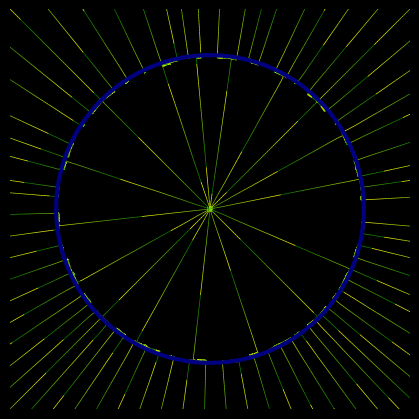

In [14]:
# Original RA
angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
ring = np.array([(np.cos(angle), np.sin(angle)) for angle in angles])
ring = np.vstack([ring, ring[0]])
animation = make_streamline_animation_from_fixed_vf(f'ring_1s_ngrid{n_grid}',
                                                    X,Y,U,V,cmap,n_steps=1*fps,fps=fps,
                                                    inv_man=ring,save_as='mp4')

28it [00:31,  1.13s/it]                        


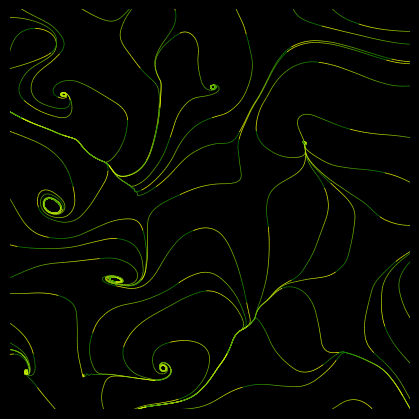

In [16]:
angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
ring = np.array([(np.cos(angle), np.sin(angle)) for angle in angles])
ring = np.vstack([ring, ring[0]])
animation = make_streamline_animation_from_fixed_vf(f'pring_1s_ngrid{n_grid}',
                                                    X,Y,perturb_u,perturb_v,cmap,n_steps=1*fps,fps=fps,
                                                    inv_man=None,save_as='mp4')

In [19]:
trajectories = simulate_network_ntimes(Nsims, perturb_grid_u, perturb_grid_v, interpol_param=1, #so that RA is not included
                                        nonlinearity_ode=vector_field_ode, 
                                        y0s=initial_conditions, maxT=1, tsteps=2001)
ring_after = trajectories[:,100,:]

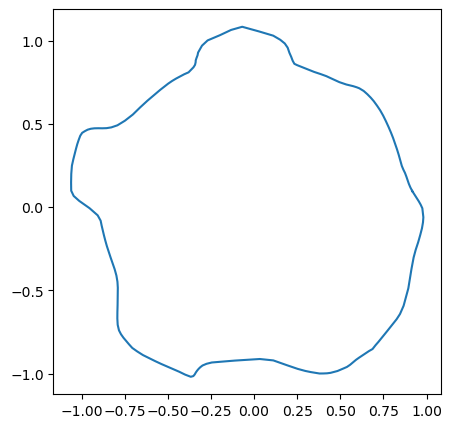

In [26]:
fig, ax = plt.subplots(figsize=(5,5))
ring_after = trajectories[:,1609,:]
ring_after = np.vstack([ring_after, ring_after[0]])
ax.plot(ring_after[:,0], ring_after[:,1], '-')

In [ ]:
def finite_difference_jacobian(t, g, x, eps=1e-5):
    n = len(x)
    J = np.zeros((n, n))
    for j in range(n):
        dx = np.zeros(n)
        dx[j] = eps
        J[:, j] = (g(t, x + dx) - g(t, x - dx)) / (2 * eps)
    return J

# def dynamical_system(t, x, f, perturb_grid_u, perturb_grid_v, interpol_param):
#     return f(t, x, perturb_grid_u, perturb_grid_v, interpol_param)

def create_vf(perturb_grid_u, perturb_grid_v, interpol_param):
    def vf(t, x, f):
        # Use the provided perturb_grid_u, perturb_grid_v, and interpol_param for the function f
        return f(t, x, perturb_grid_u, perturb_grid_v, interpol_param)
    return vf

def parallel_transport(t, v, x_traj, g, g_jacobian):
    """
    Computes dv/dt = Dg(x) v along the flow x_traj.
    """
    x = np.array([np.interp(t, np.linspace(0, 1, len(x_traj)), x_traj[:, i]) for i in range(x_traj.shape[1])])
    if g_jacobian==None:
        Dg_x = finite_difference_jacobian(t, g, x)
    else:
        Dg_x = g_jacobian(t, x)  # Compute Jacobian
    return Dg_x @ v

def integrate_system(f, g, g_jacobian, x0, v0, T=1, dt=0.01):
    """
    Integrates the system dx/dt = f(t, x) and transports v along the flow.
    """
    t_span = (0, T)
    t_eval = np.arange(0, T, dt)
    
    # Solve for flow
    sol_x = solve_ivp(f, t_span, x0, t_eval=t_eval, args=(f,))
    x_traj = sol_x.y.T  # Shape (len(t_eval), N)
    
    # Solve for parallel transport
    sol_v = solve_ivp(parallel_transport, t_span, v0, t_eval=t_eval, args=(x_traj, g, g_jacobian))
    v_traj = sol_v.y.T  # Shape (len(t_eval), N)
    
    return t_eval, x_traj, v_traj


def integrate_system_multi(f, g, x0s, v0s, perturb_grid_u, perturb_grid_v, interpol_param=1, T=1, dt=0.01):
    """
    Integrates the system dx/dt = f(x) and transports g(x) along the flow of f 
    for a grid of initial positions.
    """
    t_span = (0, T)
    t_eval = np.arange(0, T, dt)
    
    x_traj_grid = []
    v_traj_grid = []
    
    for x0, v0 in zip(x0s, v0s):
        # Solve for flow
        sol_x = solve_ivp(f, t_span, x0, t_eval=t_eval, args=(perturb_grid_u, perturb_grid_v, interpol_param))
        x_traj = sol_x.y.T  # Shape (len(t_eval), N)
        
        # Solve for parallel transport
        sol_v = solve_ivp(parallel_transport, t_span, v0, t_eval=t_eval, args=(x_traj, f, None))
        v_traj = sol_v.y.T  # Shape (len(t_eval), N)
        
        x_traj_grid.append(x_traj)
        v_traj_grid.append(v_traj)
    
    return t_eval, x_traj_grid, v_traj_grid



In [ ]:
grid_size = 50
x = np.linspace(-1, 1, grid_size)
y = np.linspace(-1, 1, grid_size)
grid_x, grid_y = np.meshgrid(x, y)
x0s = np.vstack([grid_x.ravel(), grid_y.ravel()]).T
vf = create_vf(perturb_grid_u, perturb_grid_v, interpol_param=1)
v0s = np.array([ra_ode(0, x0, vector_field_ode) for x0 in x0s])
t_eval, x_traj_grid, v_traj_grid = integrate_system_multi(vector_field_ode, ra_ode, x0s, v0s, perturb_grid_u, perturb_grid_v, interpol_param=1, T=1, dt=0.01)

TypeError: vector_field_ode() missing 3 required positional arguments: 'perturb_grid_u', 'perturb_grid_v', and 'interpol_param'

In [90]:
v_traj_grid.shape

(2500, 100, 2)

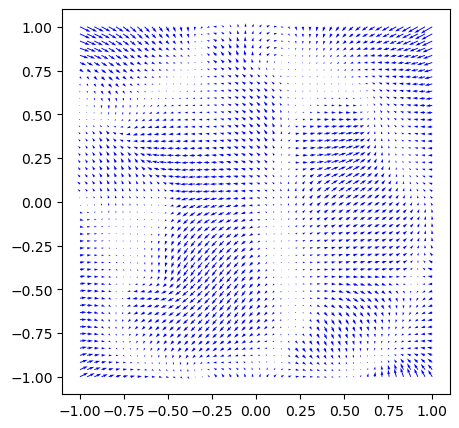

In [89]:
fig, ax = plt.subplots(figsize=(5,5))
plt.quiver(grid_x, grid_y, v0s[:,0].reshape(grid_size, grid_size), v0s[:,1].reshape(grid_size, grid_size), color='blue')

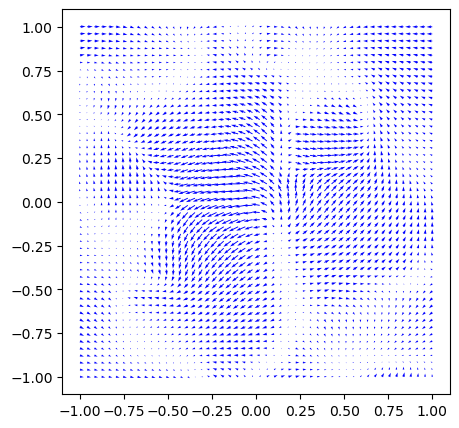

In [94]:
fig, ax = plt.subplots(figsize=(5,5))
t = 99
plt.quiver(grid_x, grid_y, v_traj_grid[:,t,0].reshape(grid_size, grid_size), v_traj_grid[:,t,1].reshape(grid_size, grid_size), color='blue')